# Predicting Machine Failure Using Machine Learning

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not a machine will breakdown based on the machine data that is collected.

We are using a synthetic dataset to make the predictions since actual machine data are generally difficult to obtain.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation


## 1. Problem Definition

In the About Dataset:
> Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

## 2. Data

The original data came from the UCI Machine Learning repository:
https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset

There is also a version of the dataset available on Kaggle:
https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

## 3. Evaluation

> If we can reach > 95% accuracy at predicting whether or not the machine will fail during the proof of concept, we'll pursue the project.

## 4. Features

The dataset consists of 10,000 data points stored as rows with 14 features in columns.

**Create Data dictionary (for easy reference)**

1. UID: unique identifier ranging from 1 to 10000
2. productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
3. air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
4. process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
5. rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
6. torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
7. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

and the label. In this case, there are two targets:

8. Target: 0 = no failure, 1 = failure
9. Failure Type: Type of Failure

In [1]:
data_dict = {
    "UID": "unique identifier ranging from 1 to 10000",
    "productID": "consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number",
    "Type": "product quality variants L, M, or H. L for low (50%), M for medium (30%), and H for high (20%)",
    "air temperature [K]": "generated using a random walk process later normalized to a standard deviation of 2 K around 300 K",
    "process temperature [K]": "generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.",
    "rotational speed [rpm]": "calculated from powepower of 2860 W, overlaid with a normally distributed noise",
    "torque [Nm]": "torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.",
    "tool wear [min]": "The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.",
    "Target": "0 = no failure, 1 = failure",
    "Failure Type": "Type of Failure"
}

## Preparing the tools

We're going to use Pandas, Patplotlib and NumPy for data analysis and manipulation.

In [2]:
# Import all the tools we need

# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
# for sklearn version 1.2+, plot_roc_curve is replaced with RocCurveDisplay
from sklearn.metrics import RocCurveDisplay

## Load The Data

In [3]:
# Import our dataset from Kaggle. Note: comment below after download is completed!
# !kaggle datasets download -d shivamb/machine-predictive-maintenance-classification

In [4]:
# Extract the csv file in the data folder
import zipfile

with zipfile.ZipFile("machine-predictive-maintenance-classification.zip") as f:
    f.extractall(path="data/")

In [5]:
df = pd.read_csv("./data/predictive_maintenance.csv")

In [6]:
# verify that the columns are the same
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the data set.")
df.shape

There are 10000 rows and 10 columns in the data set.


(10000, 10)

Note: We added the column `Type` which describes the `product quality variants: L (50%), M (30%), or H (20%)`

## Data Exploration (Exploratory Data Analysis or EDA)

Checklist:
1. What question(s) are we trying to solve?
2. What kind of data do we have and how do we treat different types e.g numerical vs categorical?
3. What's missing from the data and how do we deal with it?
4. Where are the outliers and why should we care about them?
5. How can we add, change or remove features to get more out of our data?

In [7]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [8]:
df.tail()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,No Failure


In [9]:
# check for any duplicates
df.duplicated().values.any()

False

In [10]:
# check for NaN
df.isna().values.any()

False

In [11]:
# Find out how many of each class there are in our labels
print(df["Target"].value_counts())
data_dict["Target"]

Target
0    9661
1     339
Name: count, dtype: int64


'0 = no failure, 1 = failure'

In [12]:
print(df["Failure Type"].value_counts())

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64


In [13]:
pd.crosstab(df["Target"], df["Failure Type"])

Failure Type,Heat Dissipation Failure,No Failure,Overstrain Failure,Power Failure,Random Failures,Tool Wear Failure
Target,,,,,,
0,0,9643,0,0,18,0
1,112,9,78,95,0,45


In [14]:
print(f"No Failure: {9643+18}, Failure: {112+9+78+95+45}")

No Failure: 9661, Failure: 339


From the above, when the Target column is observed against Failure Type column, we noticed some slight differences/ discrepancy:

* In the Target column, there are 9,661 No failure (Target = 0) and 339 Failure (Target = 1).
* In the Failure Type column, there are 9,652 No failure and 339 Failure.
* Also, there are 18 Random Failures that is categorized as No Failure (Target = 0)
* And, there are 9 No Failure that is categorized as Failure (Target = 1)

Let's look into the discrepancy rows.

In [15]:
# 18 Random Failures rows that is categorized under No Failure (Target = 0)
df[df["Failure Type"] == "Random Failures"]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
1221,1222,M16081,M,297.0,308.3,1399,46.4,132,0,Random Failures
1302,1303,L48482,L,298.6,309.8,1505,45.7,144,0,Random Failures
1748,1749,H31162,H,298.4,307.7,1626,31.1,166,0,Random Failures
2072,2073,L49252,L,299.6,309.5,1570,35.5,189,0,Random Failures
2559,2560,L49739,L,299.3,309.0,1447,50.4,140,0,Random Failures
3065,3066,M17925,M,300.1,309.2,1687,27.7,95,0,Random Failures
3452,3453,H32866,H,301.6,310.5,1602,32.3,2,0,Random Failures
5471,5472,L52651,L,302.7,312.3,1346,61.2,170,0,Random Failures
5489,5490,L52669,L,302.6,312.1,1499,35.0,215,0,Random Failures
5495,5496,H34909,H,302.9,312.5,1357,55.0,12,0,Random Failures


For the above rows, we might change the Target value from 0 (No Failure) to 1 (Failure) since Random Failures are still considered as Failure.

In [16]:
# 9 No Failure rows that falls under Failure (Target = 1)
df.loc[(df["Target"] == 1) & (df["Failure Type"] == "No Failure")]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
1437,1438,H30851,H,298.8,309.9,1439,45.2,40,1,No Failure
2749,2750,M17609,M,299.7,309.2,1685,28.9,179,1,No Failure
4044,4045,M18904,M,301.9,310.9,1419,47.7,20,1,No Failure
4684,4685,M19544,M,303.6,311.8,1421,44.8,101,1,No Failure
5536,5537,M20396,M,302.3,311.8,1363,54.0,119,1,No Failure
5941,5942,L53121,L,300.6,310.7,1438,48.5,78,1,No Failure
6478,6479,L53658,L,300.5,309.8,1663,29.1,145,1,No Failure
8506,8507,L55686,L,298.4,309.6,1710,27.3,163,1,No Failure
9015,9016,L56195,L,297.2,308.1,1431,49.7,210,1,No Failure


For the rows above, there are 2 options:

1. Change the Target value from 1 to 0 
OR 
2. Remove the rows from the dataset

Conclusion, we will remove the rows from the dataset.

In [17]:
# Make the changes in the pandas dataframe

# Filter rows where "Failure Type" is "Random Failures" and set "Target" to 1 for those rows
df.loc[df["Failure Type"] == "Random Failures", "Target"] = 1

# Drop rows where "Target" is 1 and "Failure Type" is "No Failure"
df.drop(df.loc[(df["Target"] == 1) & (df["Failure Type"] == "No Failure")].index, inplace=True)

In [18]:
# inspect the df again and see if the changes have been made
print(df[df["Failure Type"] == "Random Failures"].Target)
df.loc[(df["Target"] == 1) & (df["Failure Type"] == "No Failure")]

1221    1
1302    1
1748    1
2072    1
2559    1
3065    1
3452    1
5471    1
5489    1
5495    1
5509    1
5553    1
5639    1
6091    1
6913    1
6960    1
7488    1
7868    1
Name: Target, dtype: int64


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type


In [19]:
df["Target"].value_counts()

Target
0    9643
1     348
Name: count, dtype: int64

In [20]:
df["Failure Type"].value_counts()

Failure Type
No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [21]:
pd.crosstab(df["Target"], df["Failure Type"])

Failure Type,Heat Dissipation Failure,No Failure,Overstrain Failure,Power Failure,Random Failures,Tool Wear Failure
Target,,,,,,
0,0,9643,0,0,0,0
1,112,0,78,95,18,45


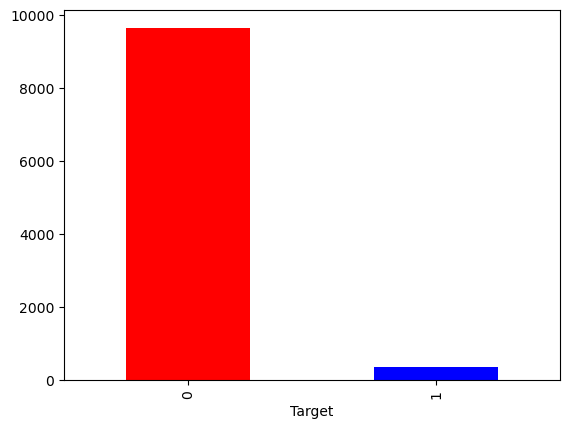

In [22]:
# Visualize our target
df.Target.value_counts().plot(kind="bar", color=["red", "blue"]);

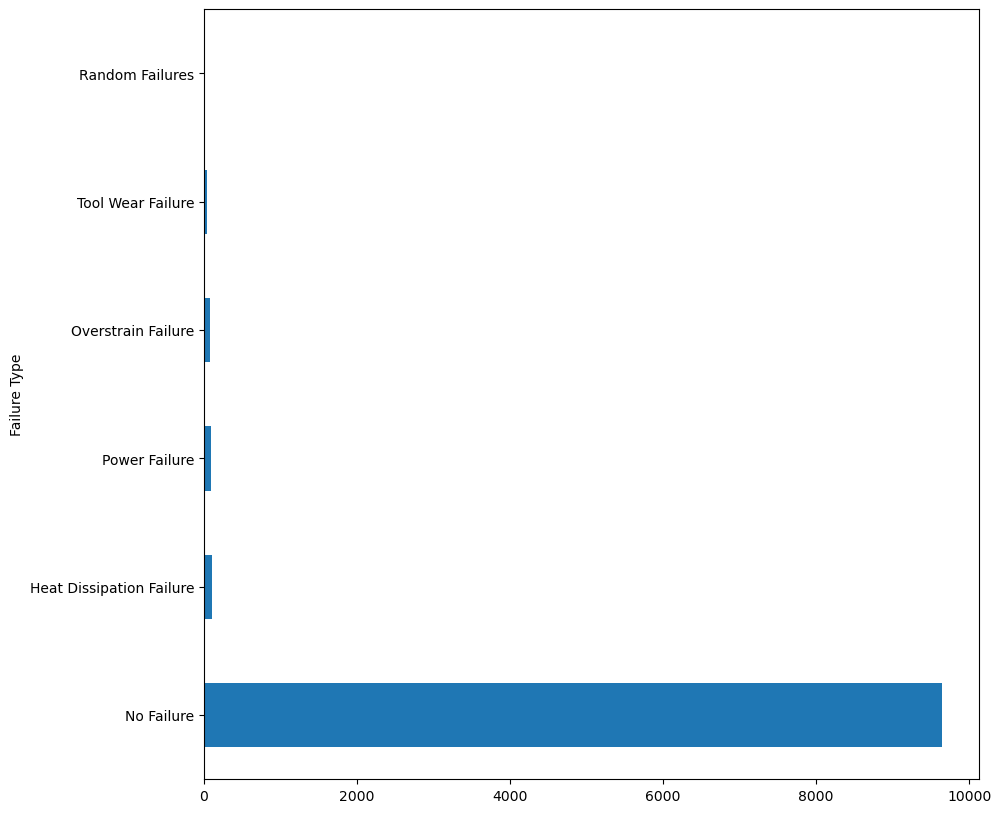

In [23]:
# Visualize our Failure Type
df["Failure Type"].value_counts().plot(kind="barh", figsize=(10, 10));

In [24]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000
mean,5000.160244,300.004634,310.005385,1538.804124,39.985377,107.942648,0.034831
std,2887.319671,2.000300,1.483990,179.321027,9.969029,63.656648,0.183362
min,1.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2499.500000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.000000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.500000,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,10000.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [25]:
df.mean(numeric_only=True)

UDI                        5000.160244
Air temperature [K]         300.004634
Process temperature [K]     310.005385
Rotational speed [rpm]     1538.804124
Torque [Nm]                  39.985377
Tool wear [min]             107.942648
Target                        0.034831
dtype: float64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9991 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      9991 non-null   int64  
 1   Product ID               9991 non-null   object 
 2   Type                     9991 non-null   object 
 3   Air temperature [K]      9991 non-null   float64
 4   Process temperature [K]  9991 non-null   float64
 5   Rotational speed [rpm]   9991 non-null   int64  
 6   Torque [Nm]              9991 non-null   float64
 7   Tool wear [min]          9991 non-null   int64  
 8   Target                   9991 non-null   int64  
 9   Failure Type             9991 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 858.6+ KB


There are a few things that we can do with the dataset:

* Convert the temperature columns from K to °C
* Since Machine Learning model cannot deal with strings, then we need to transform the categories in the Failure Type column into numbers

In [28]:
# Create new columns that converts the column "Air Temperature [K]" and "Process Temperature [K]" to Celcius [C]
df["Air temperature [C]"] = df["Air temperature [K]"] - 273.15

df["Process temperature [C]"] = df["Process temperature [K]"] - 273.15 

In [29]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature [C],Process temperature [C]
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure,24.95,35.45
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure,25.05,35.55
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure,24.95,35.35
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure,25.05,35.45
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure,25.05,35.55


In [ ]:
# Transform the categories into numbers
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_target = ["Failure Type"]

one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot",
                                  one_hot,
                                  categorical_target)],
                                  remainder="passthrough")

# transformed_y = transformer.fit_transform(X) # X is not yet defined at this stage so we will come back to this

# get the category indicators
dummies = pd.get_dummies(df[["Failure Type"]])
dummies

,Failure Type_Heat Dissipation Failure,Failure Type_No Failure,Failure Type_Overstrain Failure,Failure Type_Power Failure,Failure Type_Random Failures,Failure Type_Tool Wear Failure
0,False,True,False,False,False,False
1,False,True,False,False,False,False
2,False,True,False,False,False,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False
...,...,...,...,...,...,...
9995,False,True,False,False,False,False
9996,False,True,False,False,False,False
9997,False,True,False,False,False,False
9998,False,True,False,False,False,False


## Machine Failure by Temperature

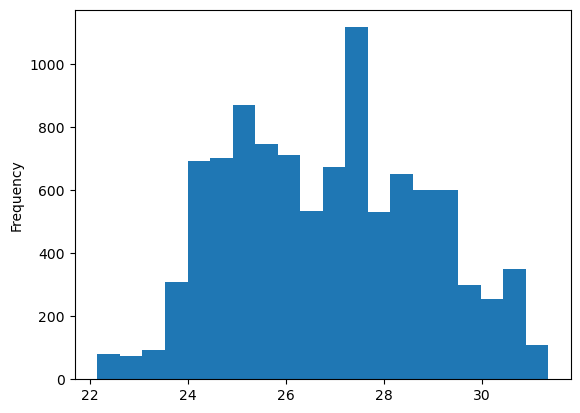

In [79]:
# df.plot.scatter(x="Air temperature [C]", y="Failure Type");
df["Air temperature [C]"].plot.hist(bins=20);

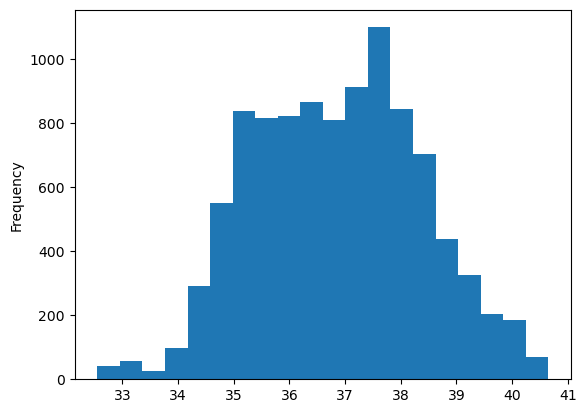

In [78]:
# df.plot.scatter(x="Process temperature [C]", y="Failure Type");
df["Process temperature [C]"].plot.hist(bins=20);

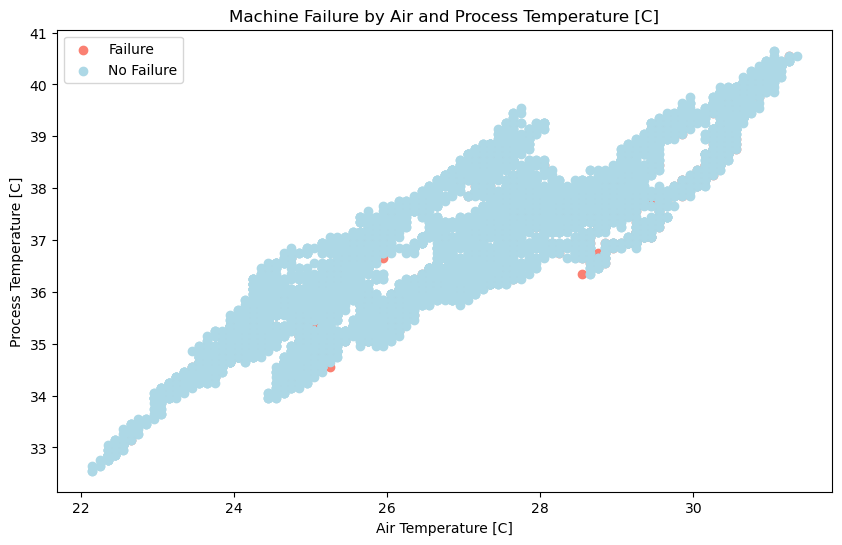

In [94]:
plt.figure(figsize=(10, 6))

plt.scatter(df["Air temperature [C]"][df.Target == 1],
            df["Process temperature [C]"][df.Target == 1],
            color="salmon")

plt.scatter(df["Air temperature [C]"][df.Target == 0],
            df["Process temperature [C]"][df.Target == 0],
            color="lightblue")

plt.title("Machine Failure by Air and Process Temperature [C]")
plt.xlabel("Air Temperature [C]")
plt.ylabel("Process Temperature [C]")
plt.legend(["Failure", "No Failure"]);

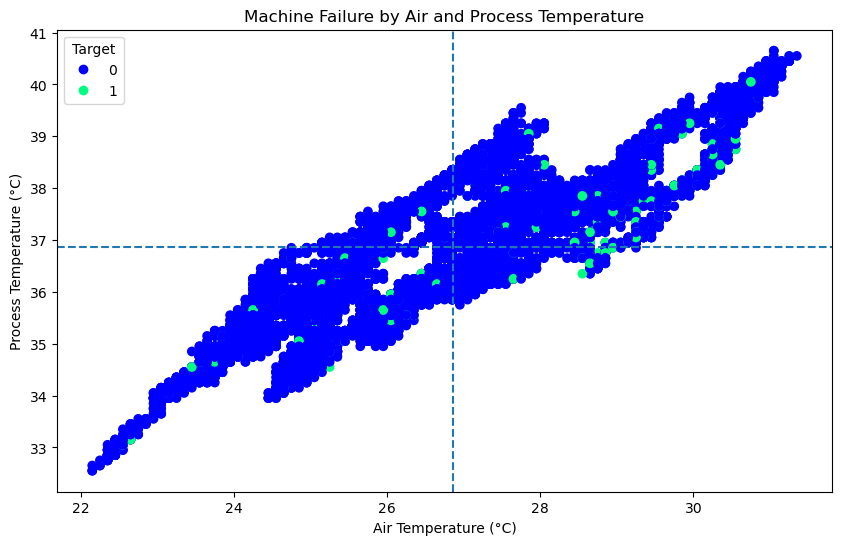

In [103]:
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(x=df["Air temperature [C]"],
                     y=df["Process temperature [C]"],
                     c=df["Target"],
                     cmap="winter")

ax.set(title="Machine Failure by Air and Process Temperature",
       xlabel="Air Temperature (°C)",
       ylabel="Process Temperature (°C)")

ax.legend(*scatter.legend_elements(), title="Target")

ax.axhline(df["Process temperature [C]"].mean(),
           linestyle="--")

ax.axvline(df["Air temperature [C]"].mean(),
           linestyle="--");

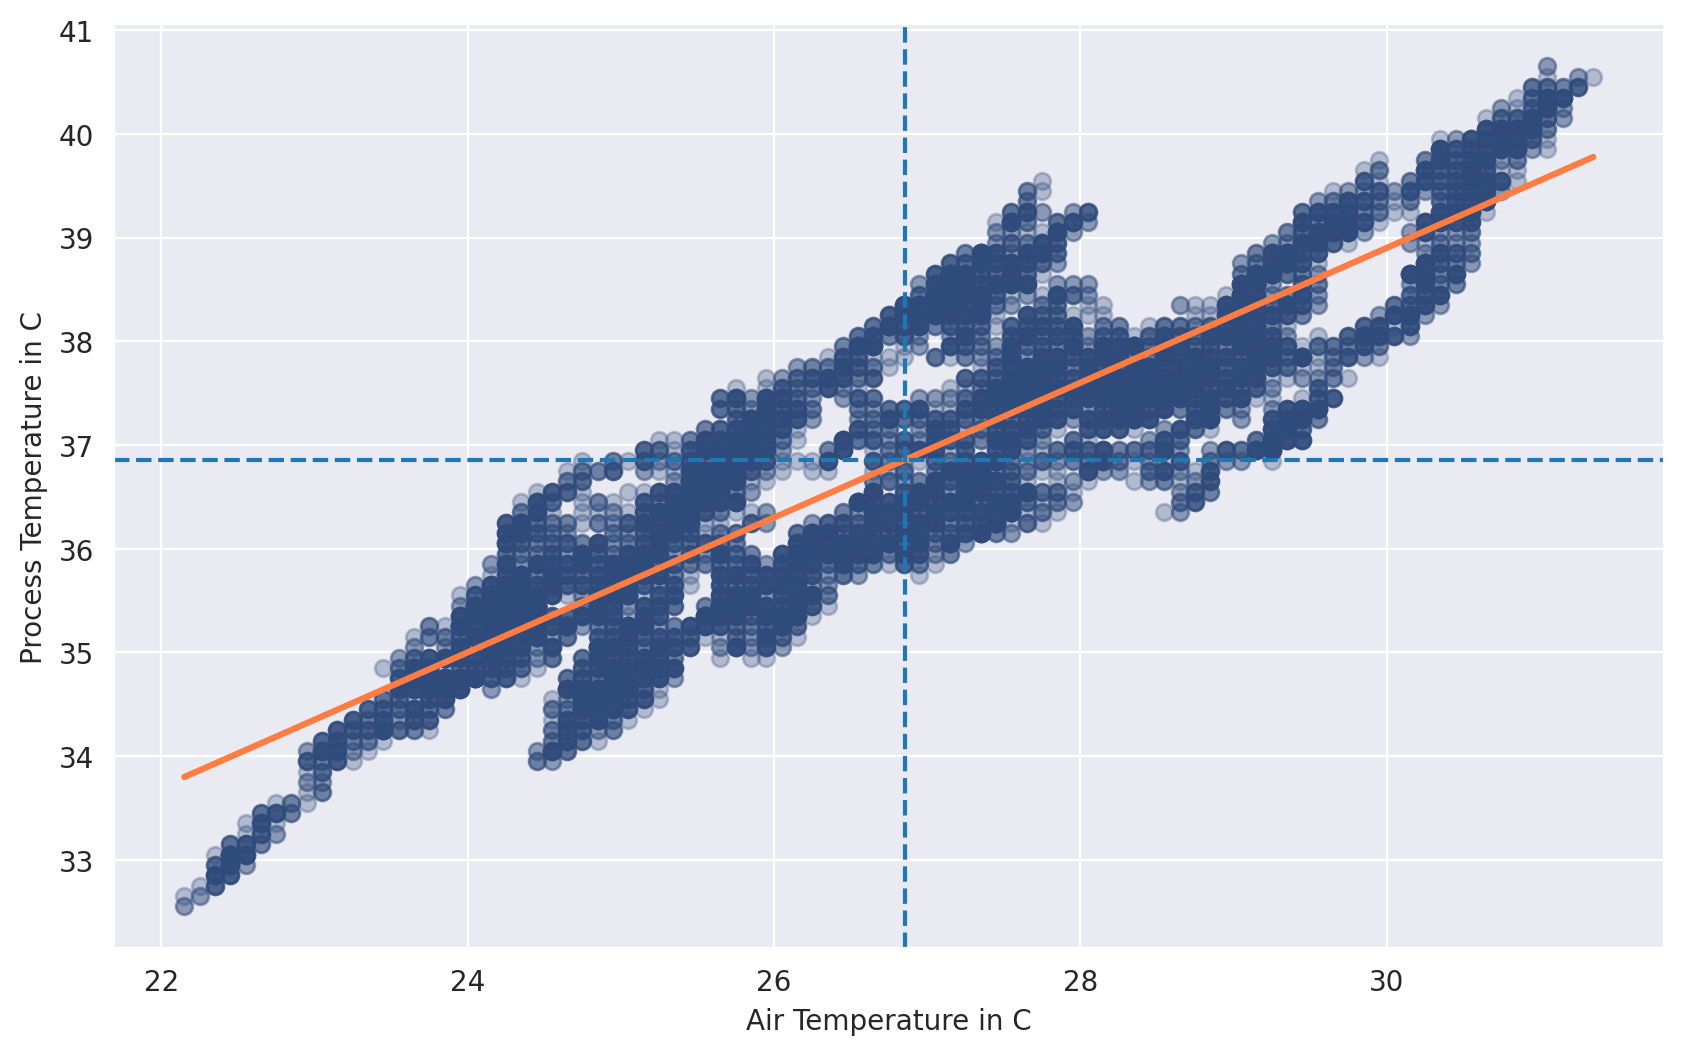

In [102]:
plt.figure(figsize=(10, 6), dpi=200)

with sns.axes_style("darkgrid"):
    ax = sns.regplot(data=df,
                     x="Air temperature [C]",
                     y="Process temperature [C]",
                     color="#2f4b7c",
                     scatter_kws={"alpha": 0.3},
                     line_kws={"color": "#ff7c43"})
    
    ax.set(xlabel="Air Temperature in C",
           ylabel="Process Temperature in C")
    
    ax.axhline(df["Process temperature [C]"].mean(),
           linestyle="--")

    ax.axvline(df["Air temperature [C]"].mean(),
           linestyle="--");

plt.show()

## Machine Failure by Rotational Speed

1538.8041237113403

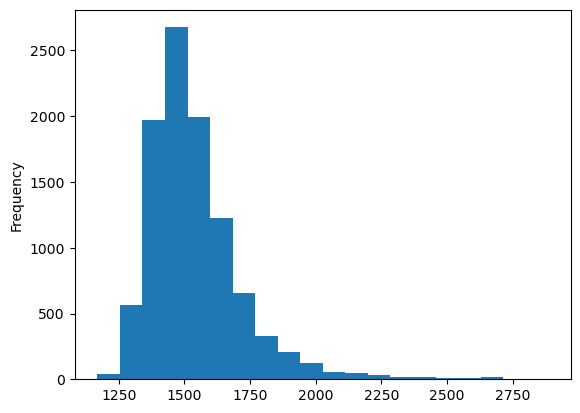

In [91]:
df["Rotational speed [rpm]"].plot.hist(bins=20);
df["Rotational speed [rpm]"].mean()

## Machine Failure by Torque

## Machine Failure by Tool Wear

## Correlation Matrix

In [106]:
df.corr(numeric_only=True)

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Air temperature [C],Process temperature [C]
UDI,1.000000,0.117728,0.324780,-0.006684,0.003239,-0.011147,-0.024384,0.117728,0.324780
Air temperature [K],0.117728,1.000000,0.876088,0.022951,-0.014061,0.014242,0.084519,1.000000,0.876088
Process temperature [K],0.324780,0.876088,1.000000,0.019550,-0.014367,0.013885,0.039850,0.876088,1.000000
Rotational speed [rpm],-0.006684,0.022951,0.019550,1.000000,-0.874981,-0.000063,-0.045525,0.022951,0.019550
Torque [Nm],0.003239,-0.014061,-0.014367,-0.874981,1.000000,-0.002770,0.191680,-0.014061,-0.014367
Tool wear [min],-0.011147,0.014242,0.013885,-0.000063,-0.002770,1.000000,0.105321,0.014242,0.013885
Target,-0.024384,0.084519,0.039850,-0.045525,0.191680,0.105321,1.000000,0.084519,0.039850
Air temperature [C],0.117728,1.000000,0.876088,0.022951,-0.014061,0.014242,0.084519,1.000000,0.876088
Process temperature [C],0.324780,0.876088,1.000000,0.019550,-0.014367,0.013885,0.039850,0.876088,1.000000


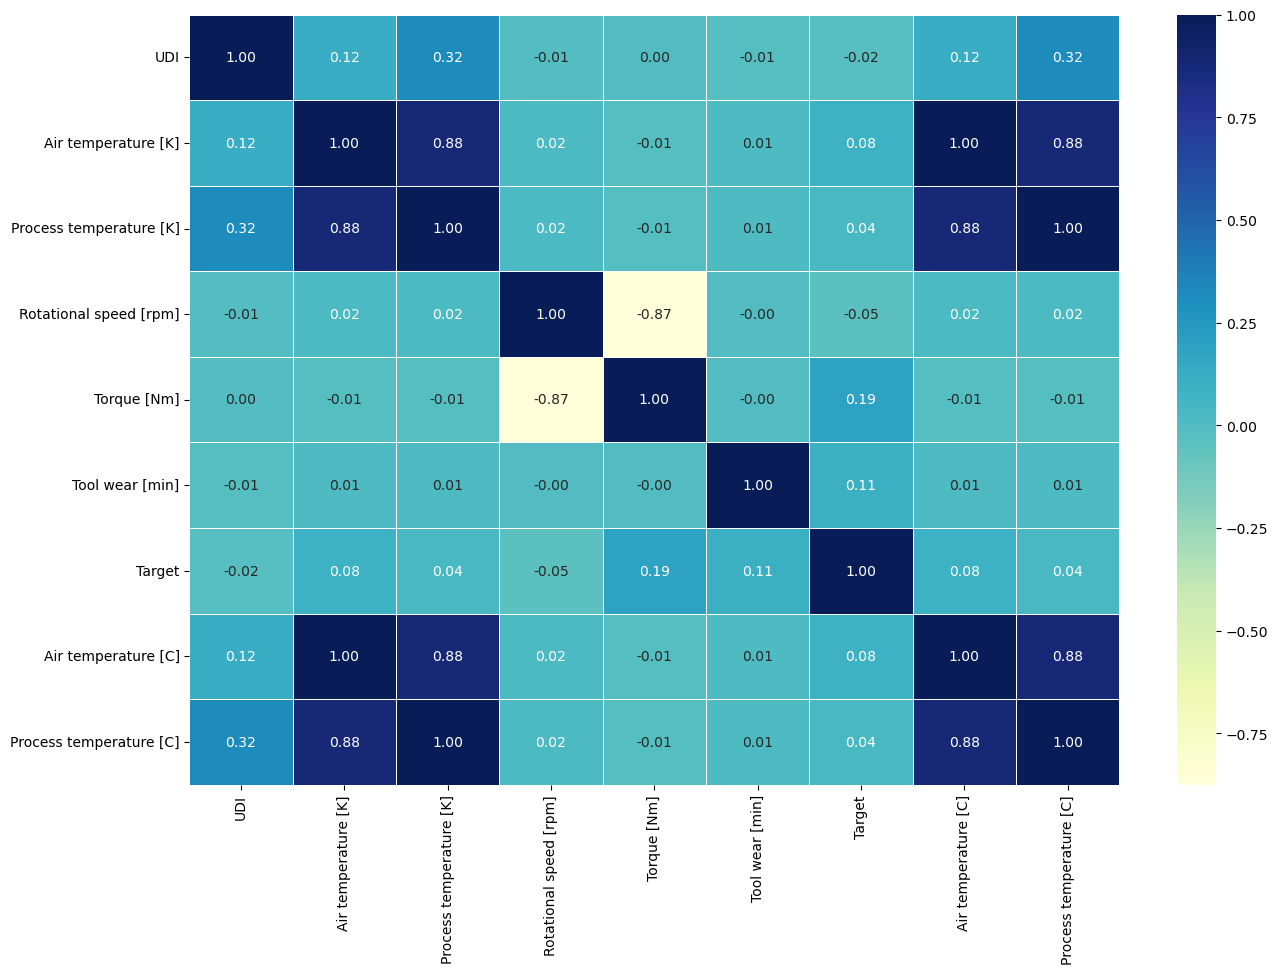

In [107]:
corr_matrix = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");

We can see from the above correlation matrix, that:
1. `Air temperature` and `Process temperature` columns have the highest/ strongest positive correlation coefficient at **0.88**
    * Example: As the machine runs, it generates heat, which elevates both the air temperature around it and the temperature of internal processes.

2. `Torque [Nm]` has a negative correlation coefficient of **-0.87** with `Rotational speed [rpm]`
    * Torque is inversely proportional to speed

3. `Torque [Nm]` has the highest/ strongest positive correlation coefficient with `Target` at **0.19**

## 5. Modelling

In [114]:
# Split our dataset into X and y
X = df.drop(["Target", "Failure Type", "UDI", "Product ID", "Type", "Air temperature [K]", "Process temperature [K]"], axis=1) # drop two Target columns and Air Temperature and Process Temperature in Kelvin
y = df["Target"] # since there are 2 target columns, we will start with one first

In [115]:
X.head()

,Rotational speed [rpm],Torque [Nm],Tool wear [min],Air temperature [C],Process temperature [C]
0,1551,42.8,0,24.95,35.45
1,1408,46.3,3,25.05,35.55
2,1498,49.4,5,24.95,35.35
3,1433,39.5,7,25.05,35.45
4,1408,40.0,9,25.05,35.55


In [116]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Target, dtype: int64

In [117]:
# split our dataset into training and testing where 80% will be for training and 20% will be for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
# check the shape
len(X_train), len(y_train), len(X_test), len(y_test)

(7992, 7992, 1999, 1999)

It's time to build our Machine Learning model. We will train (find patterns) using the train data set. Then, we will test (use the patterns found) using the test data set. 

We are going to try 3 different models:

1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier

In [119]:
# Setup a function to evaluate all 3 ML Models

# Put all models in a dictionary
models = {"LogisticRegression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest Clf": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    Models: A dict of different SKLearn ML Models.
    X_train: Training data (no labels).
    X_test: Testing data (no labels).
    y_train: Training labels.
    y_test: Testing labels.
    """
    # Set random seed for reproducability
    np.random.seed(42)
    # Make an empty dict to keep the model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [120]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

{'LogisticRegression': 0.9659829914957478,
 'KNN': 0.9664832416208105,
 'Random Forest Clf': 0.9804902451225613}

### Model Comparison

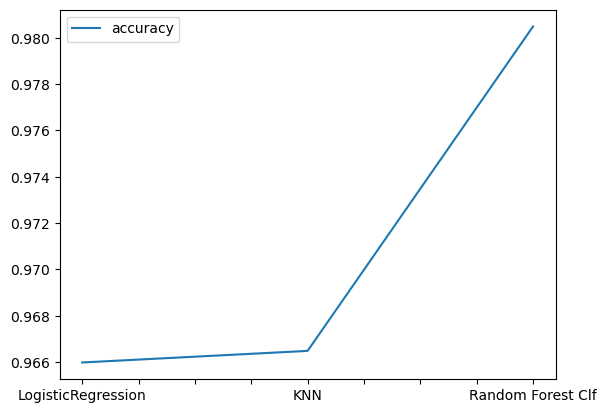

In [122]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.line();

The above is our baseline model and we will see if it can be improved further by Hyperparameter Tuning.

### Hyperparameter Tuning with RandomizedSearchCV

We are going to tune the RandomForestClassifier() model since it has the highest accuracy score.

In [123]:
np.random.seed(42)

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [124]:
# Find the best hyperparameters
rs_rf.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

In [125]:
# Evaluate the RandomizedSearch RandomForestClassifier model
rs_rf_after_tuning = rs_rf.score(X_test, y_test)

In [127]:
print(f"Before tuning: {model_scores['Random Forest Clf']}")
print(f"After tuning: {rs_rf_after_tuning}")

Before tuning: 0.9804902451225613
After tuning: 0.9819909954977488


We can see that after hyperparameter tuning for RandomForestClassifier, the score improved slightly.

Let's use GridSearchCV to see if we can improve further our RandomForestClassifier model.

### Hyperparameter Tuning with GridSearchCV

In [154]:
# np.random.seed(42)

# Create a different hyperparameter for our RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 100),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

gs_rf = GridSearchCV(RandomForestClassifier(),
                     param_grid=rf_grid,
                     cv=2,
                     verbose=True)

# Fit grid hyperparameter search model
gs_rf.fit(X_train, y_train)

Fitting 2 folds for each of 3600 candidates, totalling 7200 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                         'n_estimators': array([ 10, 110, 210, 310, 410, 510, 610, 710, 810, 910])},
             verbose=True)

In [155]:
# Check for the best hyperparameter in GridSeach
gs_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 110}

In [156]:
# Evaluate the GirdSearch RandomForestClassifier model
gs_rf.score(X_test, y_test)

0.9824912456228114

## Evaluating our tuned Machine Learning Classifier, beyond Accuracy

* ROC curve and AUC score
* Confusion Matrix
* Classification Report (cross-validated)
* Precision
* Recall
* F1 Score

In [157]:
# To make comparison and evaluate our trained model, we first need to make predictions
y_preds = gs_rf.predict(X_test)
# y_preds = rs_rf.predict(X_test)
y_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### ROC (Receiver Operating Characteristics) Curve and AUC (Area under ROC Curve) Score

ROC curve is a graphical plot that visualizes the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

ROC curve is created by plotting the True Positive Rate (TP) against the False Positive Rate at various threshold settings.

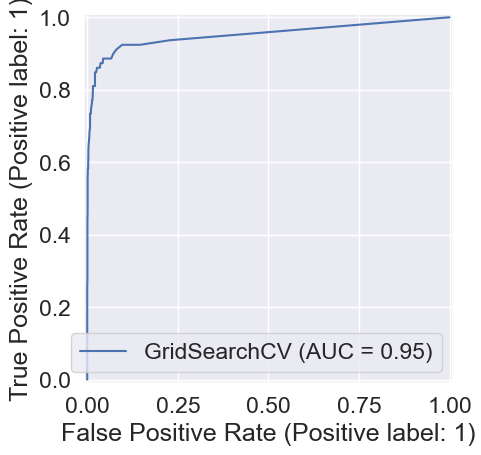

In [158]:
RocCurveDisplay.from_estimator(estimator=gs_rf, X=X_test, y=y_test)
# RocCurveDisplay.from_estimator(estimator=rs_rf, X=X_test, y=y_test)

### Confusion Matrix

We can visualize the True Positives, True Negatives, False Positives and False Negatives in a Confusion Matrix

In [159]:
print(confusion_matrix(y_test, y_preds))

[[1914    6]
 [  29   50]]


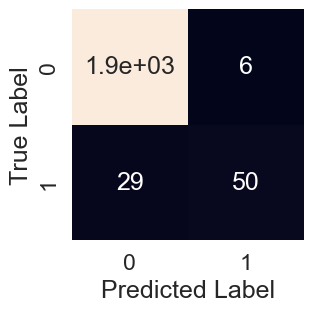

In [160]:
# Visualize the CM with Seaborn
sns.set_theme(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

plot_conf_mat(y_test, y_preds)

### Classification Report (Cross-Validated)

In [161]:
# Check for the best hyperparameter
gs_rf.best_params_
# rs_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 110}

In [162]:
# Create a new classifier with best parameters
clf = RandomForestClassifier(n_estimators=110,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_depth=None)
# clf = RandomForestClassifier(n_estimators=510,
#                              min_samples_split=14,
#                              min_samples_leaf=1,
#                              max_depth=None)

In [163]:
# Cross-validated Accuracy
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")

# Find the mean cross-validated accuracy
cv_acc = np.mean(cv_acc)
cv_acc

0.8873901915922927

In [164]:
# Cross-validate Precision
cv_precision = cross_val_score(clf,
                               X,
                               y,
                               cv=5,
                               scoring="precision")

# Find the mean cross-validated precision
cv_precision = np.mean(cv_precision)
cv_precision

0.5932602227493868

In [165]:
# Cross-validated Recall
cv_recall = cross_val_score(clf,
                            X,
                            y,
                            cv=5,
                            scoring="recall")

# Find the mean cross-validated recall
cv_recall = np.mean(cv_recall)
cv_recall

0.48331262939958586

In [166]:
# Cross-validate F1 score
cv_f1 = cross_val_score(clf,
                        X,
                        y,
                        cv=5,
                        scoring="f1")

# find the mean cross-validate F1
cv_f1 = np.mean(cv_f1)
cv_f1

0.44568849601136745

Now, let's visualize our Cross-Validated Metrics

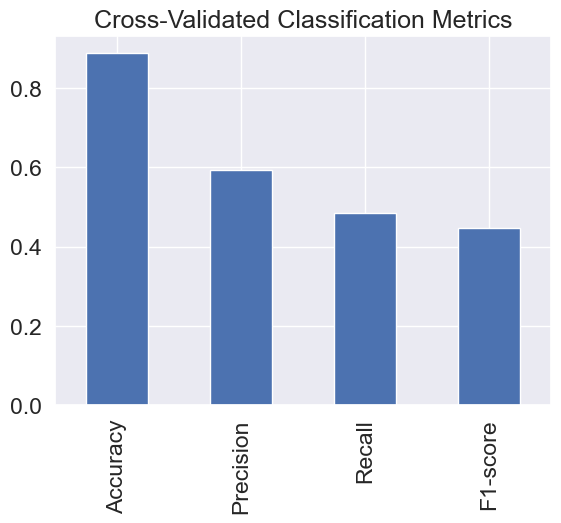

In [167]:
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                           "Precision": cv_precision,
                           "Recall": cv_recall,
                           "F1-score": cv_f1},
                           index=[0])

cv_metrics.T.plot(kind="bar",
                  title="Cross-Validated Classification Metrics",
                  legend=False);

## Feature Importance

Which features contributes to the success of the model predictions?

Feature importance is a step that involves calculating the score of for all input features in a model to establish the importance of each feature in the decision-making process.

The higher the score for a feature, the larger the effect it has on the model to predict a certain variable.

### Permutation Feature Importance

When we permute the values of a feature and the permuting causes a huge change in error, it means the feature is important for our model.

It is applied by:

1. Calculating the Mean-Squared Error (MSE) with the original values
2. Shuffling the values for the features and make predictions
3. Calculating the mean squared error with the shuffled values
4. Comparing the difference
5. Sorting the differencs in descending order to get the features with most to least importance

In [168]:
# Fit an instance to a RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [169]:
# Check feature_importances in RandomForestClassifier
clf.feature_importances_

array([0.21614614, 0.33172025, 0.16722208, 0.14471391, 0.14019763])

In [170]:
# Match feature importances to columns
feature_dict = dict(zip(X, clf.feature_importances_))
feature_dict

{'Rotational speed [rpm]': 0.21614613549276593,
 'Torque [Nm]': 0.33172024605716766,
 'Tool wear [min]': 0.16722207824991617,
 'Air temperature [C]': 0.1447139074981027,
 'Process temperature [C]': 0.1401976327020475}

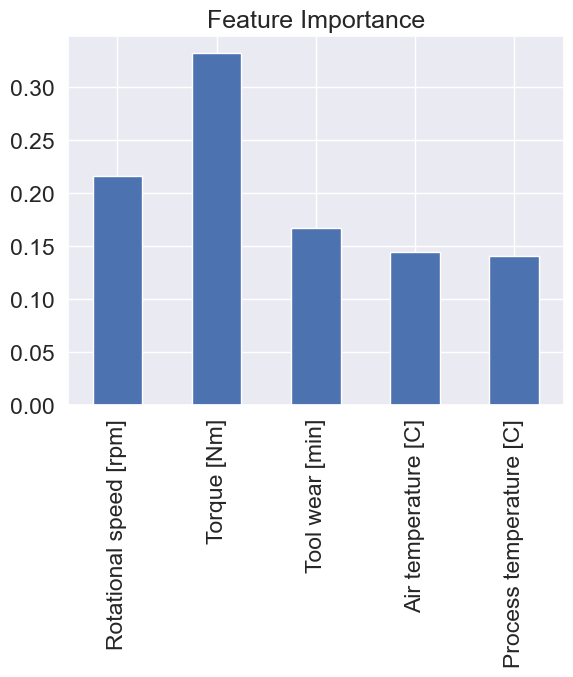

In [171]:
# Visualize the feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot(kind="bar",
                  title="Feature Importance",
                  legend=False);

In [172]:
pd.crosstab(df["Torque [Nm]"], df.Target)

Target,0,1
Torque [Nm],,
3.8,0,1
4.2,0,1
4.6,0,1
5.6,0,1
5.8,0,1
...,...,...
73.6,0,1
74.5,0,1
75.4,0,1


# Saving and Loading Trained Machine Learning Model

In [174]:
# pickle requires a python object to save
import pickle

# save an existing model to file
pickle.dump(gs_rf, open("gs_random_forest_clf_1.pkl", "wb"))

In [175]:
# Load a saved model
loaded_pickle_model = pickle.load(open("gs_random_forest_clf_1.pkl", "rb"))

In [176]:
# create a function for evaluating our model
from sklearn.metrics import accuracy_score

def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels Vs. y_pred labels on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {
        "accuracy": round(accuracy, 2),
        "precision": round(precision, 2),
        "recall": round(recall, 2),
        "f1": round(f1, 2)
    }
    print(f"Accuracy score: {accuracy*100:.2f} %")
    print(f"Precision score: {precision:.2f}")
    print(f"Recall score: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict

In [177]:
# check by making a prediction
pickle_y_preds = loaded_pickle_model.predict(X_test)
evaluate_preds(y_test, pickle_y_preds)

Accuracy score: 98.25 %
Precision score: 0.89
Recall score: 0.63
F1 score: 0.74


{'accuracy': 0.98, 'precision': 0.89, 'recall': 0.63, 'f1': 0.74}